## Homework 08: Classification

**Due:** Midnight on March 23 (with a 2-hour grace period)  


### Overview

In this final homework before starting our course project, we will introduce the essential machine learning paradigm of **classification**. We will work with a well-known Kaggle dataset—the Pima Indians Diabetes dataset—to determine whether an individual has diabetes (1) or not (0). This is a binary classification task.

As we’ve discussed in this week’s lessons, the classification workflow is similar to what we’ve done for regression, with a few key differences:
- Instead of `RepeatedKFold` we use `RepeatedStratifiedKFold` (read the docs to understand the difference)
- We use classification metrics (e.g., accuracy, precision, recall, F1-score) instead of regression metrics--for simplicity we'll just use accuracy in this homework. 

For this assignment, you’ll build two models and measure their performance using the accuracy metric. 
1. A **logistic regression** classifier as a baseline.
2. One of the **ensemble** classifiers of your choice.

Because we’ve already covered much of the workflow in our regression assignments, this homework is intentionally concise and less prescriptive.

### Grading

There are 5 graded problems, each worth 5 points, for a total of 25 points.

In [25]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,GridSearchCV,LeaveOneOut
from sklearn.ensemble        import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing   import StandardScaler
from tqdm                    import tqdm

from collections import Counter

# globals

random_state = 42


### Problem One:  Load, Explore, and Preprocess the Kaggle Pima Indians Diabetes Dataset 

In the follow cell(s), 
- Download the dataset from Kaggle
- Perform some simple EDA using `.head()`, `.info()` and `.hist()`
    - When using a classification dataset, **always** look to see whether the target is balanced (approximately equal numbers of classes) or not. 
- Create the feature set `X` and the target set `y` (using `Outcome` as the target)
- Scale `X` using `StandardScalar` (since the classification models often prefer this)
- Split the dataset into 80% training and 20% testing sets
- Verify that the graded answer is correct

[Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

In [8]:
# Import Data
# Download latest version
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Path to dataset files:", path)

# set variables
kaggle_dataset_path = "uciml/pima-indians-diabetes-database"
kaggle_dataset_file_name = "diabetes.csv"
print(f"Path to kaggle dataset: {kaggle_dataset_path}")
print(f"Kaggle dataset file name: {kaggle_dataset_file_name}")

# download the data set
kaggle_dataset_local_path = kagglehub.dataset_download(kaggle_dataset_path)
print(f"Path to downloaded file: {kaggle_dataset_local_path}")

# read csv file to pandas dataframe
kaggle_dataset_local_path_to_file = os.path.join(kaggle_dataset_local_path, kaggle_dataset_file_name)
kaggle_dataset_raw = pd.read_csv(kaggle_dataset_local_path_to_file)

# copy dataframe for EDA
df = kaggle_dataset_raw.copy()

# show top rows
df.head()

Path to dataset files: C:\Users\serge\.cache\kagglehub\datasets\uciml\pima-indians-diabetes-database\versions\1
Path to kaggle dataset: uciml/pima-indians-diabetes-database
Kaggle dataset file name: diabetes.csv
Path to downloaded file: C:\Users\serge\.cache\kagglehub\datasets\uciml\pima-indians-diabetes-database\versions\1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

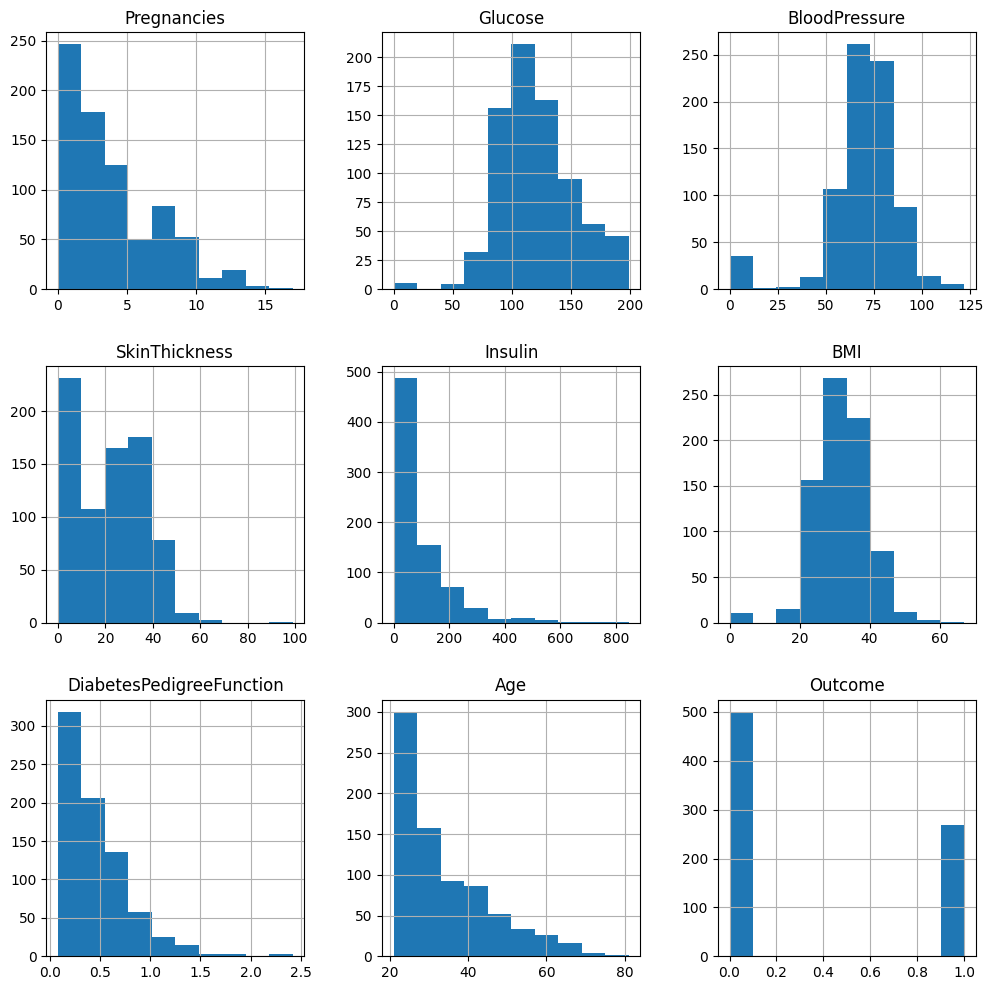

In [10]:
df.hist(figsize=(12, 12))

Note: Target/Outcome variable is unbalanced. ~ 500 / 250 

Outcome
0    500
1    268
Name: count, dtype: int64


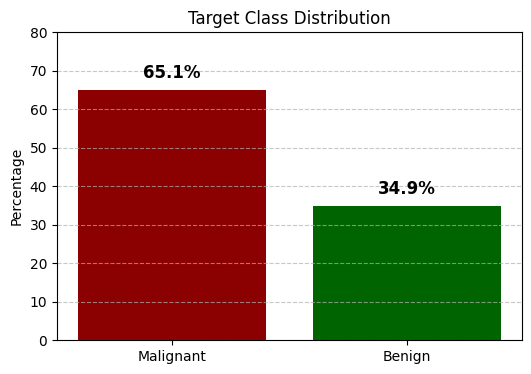

In [11]:
# Count occurrences of each class and convert to percentages

class_counts = df['Outcome'].value_counts()
class_counts_percentage = df['Outcome'].value_counts(normalize=True) * 100 

print(class_counts)

# Create bar chart
plt.figure(figsize=(6, 4))
plt.title('Target Class Distribution')

bars = plt.bar(class_counts_percentage.index, class_counts_percentage.values, color=['darkred', 'darkgreen'])

# Label each bar with its percentage (placed above bars)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 2,  # Move above the bar
             f'{bar.get_height():.1f}%',  # Format as percentage
             ha='center', va='bottom', color='black', fontsize=12, fontweight='bold')

# Labels and styling
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['Malignant', 'Benign'])
plt.ylim(0, 80)  # Set y-axis to 100% scale
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid

plt.show()


In [ ]:
# Split the data into features and target
target_feature_name = 'Outcome'
X = df.drop(columns=[target_feature_name])
y = df[target_feature_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,train_size=0.8, random_state=42)

# Scale the features (only for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Problem 1 Graded Answer

In [20]:
# Nothing to do, but you might want to check and make sure this is correct

a1 = (X_train.shape,X_test.shape)                          

print(f'a1 = {a1}')              # Do not change this line, and DO NOT print anything else in this cell

a1 = ((614, 8), (154, 8))


## Interlude: Wrapper Functions for Running Classification Models

The following cells are adapted from the Week 7 homework in order to use accuracy as the error metric. You can easily modify these
if you wish to consider other metrics.  


**Note:** `sweep_parameter` sets `X_train` etc. to default values using the global values for `X_train` etc. you created in problem 1.  Should work fine as is, but you can always just ignore the defaults and assign the parameters explicitly. 


In [21]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    # Use RepeatedStratifiedKFold for classification to preserve class distribution
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy  = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing accuracy
    train_preds    = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_preds     = model.predict(X_test)
    test_accuracy  = accuracy_score(y_test, test_preds)
    
    return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy


In [22]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
                   ):

    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf  # since higher accuracy is better
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)
        
        # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_accuracies.append(mean_cv_accuracy)
        std_cvs.append(std_cv_accuracy)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Early-stopping logic: maximize accuracy
        if mean_cv_accuracy > best_accuracy + delta:
            best_accuracy = mean_cv_accuracy
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # Use only as many parameter values as computed
        partial_param_list = parameter_list[:len(cv_accuracies)]
        
        # Check if our parameter list is Boolean for proper labeling
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        # ----- First plot: Accuracy -----
        ax1.set_title(f"Accuracy vs {param}")
        
        ax1.plot(x_vals,
                 cv_accuracies,
                 marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals,
                 train_accuracies,
                 marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals,
                 test_accuracies,
                 linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]],
                    [max_cv_accuracy],
                    marker='x', label="Best CV Accuracy", color='red')
        
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Standard Deviation -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Accuracy Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


## Problem Two: Classification using Logistic Regression (Baseline)  

For this problem,
- Read the docs for `LogisticRegression`
- Run the model with `class_weight = 'balanced'` and `max_iter=1000` using `run_model` or just your own code. 
- Answer the graded questions


Logistic Regression Results:
K = 5
Cross-Validation Accuracy: 0.7606
Test Accuracy: 0.7532
              precision    recall  f1-score   support

           0     0.8144    0.7980    0.8061        99
           1     0.6491    0.6727    0.6607        55

    accuracy                         0.7532       154
   macro avg     0.7318    0.7354    0.7334       154
weighted avg     0.7554    0.7532    0.7542       154



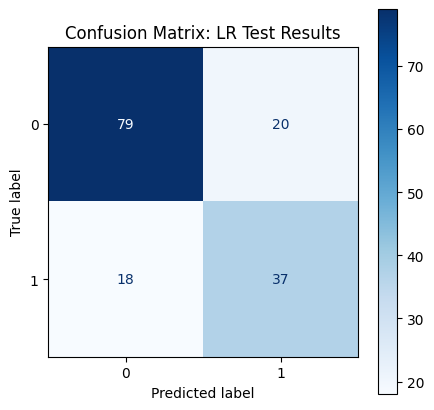

In [31]:
# Initialize Logistic Regression model with default parameters
model_LR = LogisticRegression()

loo = LeaveOneOut()

K = 5
# Perform Cross-Validation
cv_scores = cross_val_score(model_LR, X_train_scaled, y_train, cv=K, scoring='accuracy')

# Fit model on the entire training set
model_LR.fit(X_train_scaled, y_train)

# Predictions
y_pred_log_reg = model_LR.predict(X_test_scaled)

# Print results
print("\nLogistic Regression Results:")
if K == loo:
    print("Leave_One Out CV")
else:
    print(f"K = {K}")

p2_mean_cv_scores = np.mean(cv_scores)
p2_test_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f"Cross-Validation Accuracy: {p2_mean_cv_scores:.4f}")
print(f"Test Accuracy: {p2_test_accuracy:.4f}")
print(classification_report(y_test, y_pred_log_reg, digits=4))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(model_LR, X_test_scaled, y_test, cmap='Blues', ax=ax)
ax.set_title("Confusion Matrix: LR Test Results")
plt.show()



### Problem 2.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [30]:
# Insert the mean CV accuracy

a2a = p2_mean_cv_scores                             # Just to get it to run without errors, put your answer here                       

print(f'a2a = {a2a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2a = 0.7606


### Problem 2.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [32]:
# Insert the test accuracy

a2b = p2_test_accuracy                              # Just to get it to run without errors, put your answer here                          

print(f'a2b = {a2b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2b = 0.7532


## Problem Three: Classification using Ensemble Methods  

For this problem,
- Choose one of the ensemble methods for classification (see the first code cell above)
- Read about the hyperparameters for the model in the `sklearn` docs
- Tune the model for best performance using the wrapper functions and/or grid search as needed
- Answer the graded questions


In [55]:
n_repeats        = 10

In [51]:
# Define the parameters for the  RandomForestClassifier
Default_Parameters_RandomForest = {
    'n_estimators': 100,            # Number of base estimators in the ensemble
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_leaf_nodes': None,
    'ccp_alpha': 0.01
}

Sweeping n_estimators: 100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


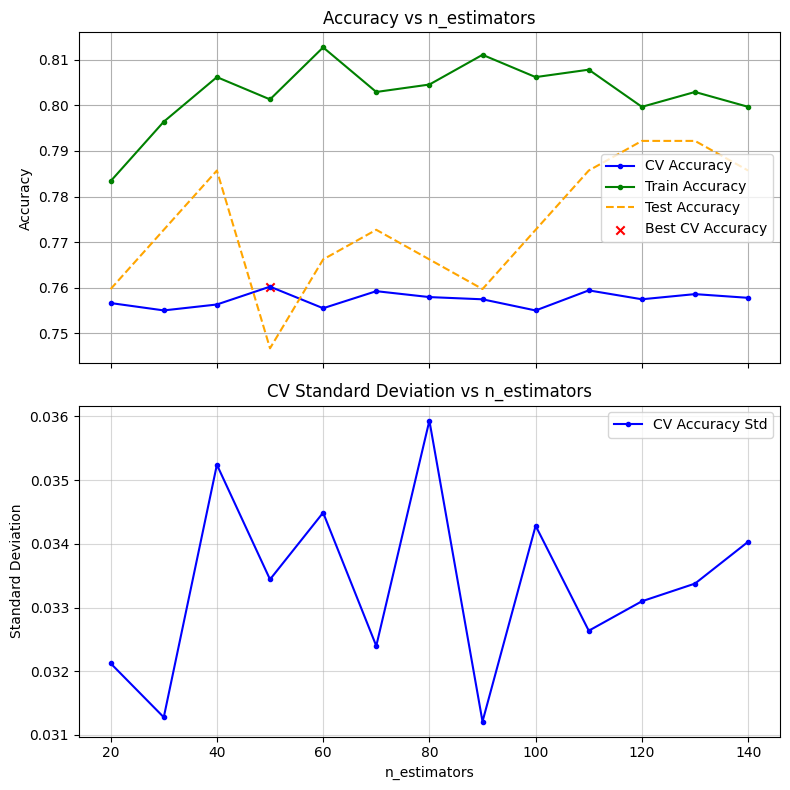

Execution Time: 00:00:29
Parameters_best: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'ccp_alpha': 0.01, 'accuracy_found': np.float64(0.7602652272424362)}


In [ ]:
model = RandomForestClassifier
Parameters = Default_Parameters_RandomForest.copy()
param = 'n_estimators'
sweep_name="RandomForestClassifier"
parameter_list = range(20,150,10)   

Parameters_best = sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = n_repeats )
print(f"Parameters_best: {Parameters_best}")

In [59]:
# GradientBoostingClassifier

Default_Parameters_GradientBoosting = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'random_state'            : 42               # Controls randomness of boosting. Useful for reproducibility.
}


Sweeping n_estimators: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


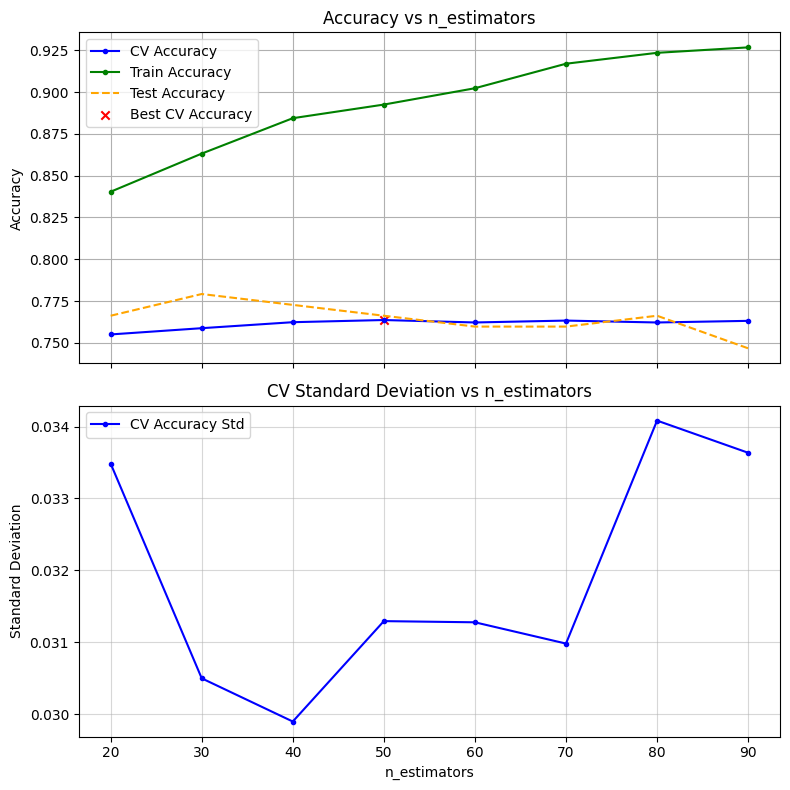

Execution Time: 00:00:11
Parameters_best: {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'accuracy_found': np.float64(0.7636691989870719)}


In [67]:
model = GradientBoostingClassifier
Parameters = Default_Parameters_GradientBoosting.copy()
param = 'n_estimators'
sweep_name="GradientBoostingClassifier"
parameter_list = range(20,100,10)   

Parameters_best = sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = n_repeats )
print(f"Parameters_best: {Parameters_best}")

Sweeping learning_rate: 100%|██████████| 13/13 [00:16<00:00,  1.31s/it]


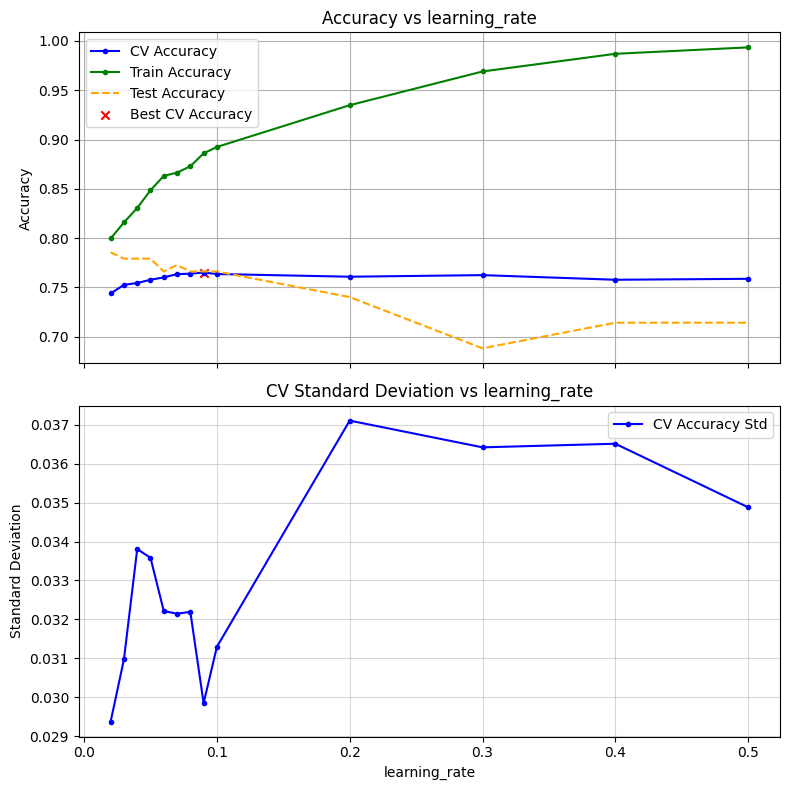

Execution Time: 00:00:17
Parameters_best: {'learning_rate': 0.09, 'n_estimators': 50, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'accuracy_found': np.float64(0.7651312808210049)}


In [68]:
model = GradientBoostingClassifier
Parameters = Parameters_best.copy()
param = 'learning_rate'
sweep_name="GradientBoostingClassifier"
parameter_list = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5] 

Parameters_best = sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = n_repeats )
print(f"Parameters_best: {Parameters_best}")

Sweeping max_depth: 100%|██████████| 18/18 [01:46<00:00,  5.92s/it]


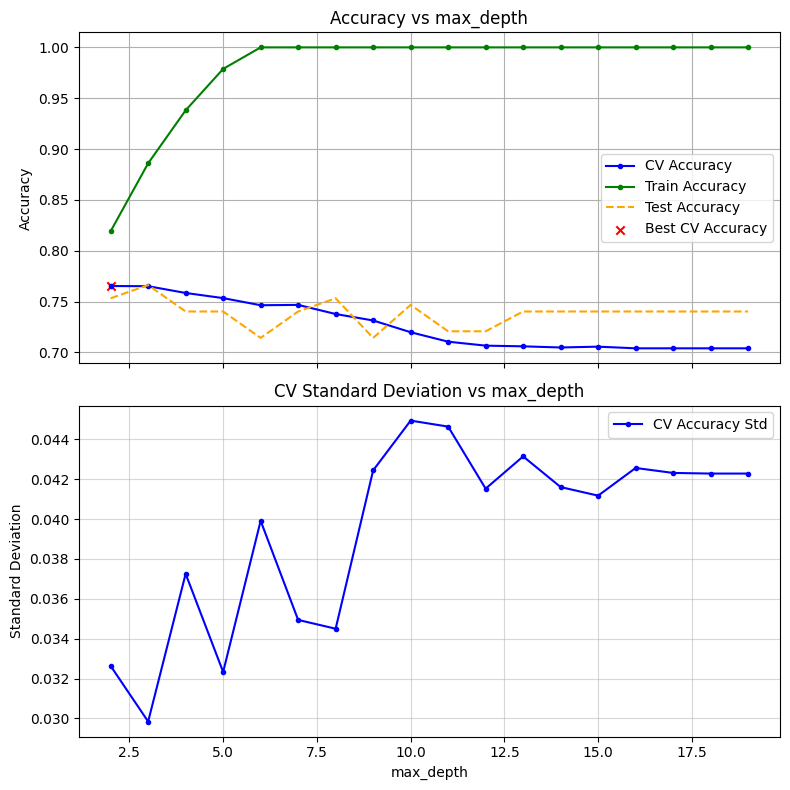

Execution Time: 00:01:46
Parameters_best: {'learning_rate': 0.09, 'n_estimators': 50, 'max_depth': 2, 'max_features': None, 'random_state': 42, 'accuracy_found': np.float64(0.7653085432493669)}


In [69]:
model = GradientBoostingClassifier
Parameters = Parameters_best.copy()
param = 'max_depth'
sweep_name="GradientBoostingClassifier"
parameter_list = range(2,20)

Parameters_best = sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = n_repeats )
print(f"Parameters_best: {Parameters_best}")

Sweeping max_features: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


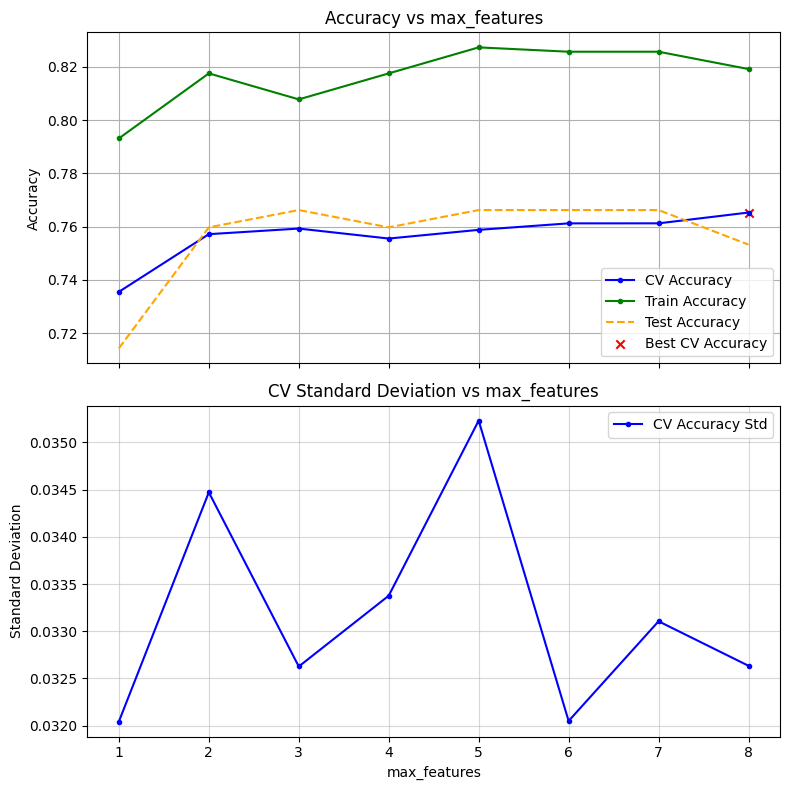

Execution Time: 00:00:07
Parameters_best: {'learning_rate': 0.09, 'n_estimators': 50, 'max_depth': 2, 'max_features': 8, 'random_state': 42, 'accuracy_found': np.float64(0.7653085432493669)}


In [70]:
model = GradientBoostingClassifier
Parameters = Parameters_best.copy()
param = 'max_features'
sweep_name="GradientBoostingClassifier"
parameter_list =range(1,X.shape[1]+1)

Parameters_best = sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = n_repeats )
print(f"Parameters_best: {Parameters_best}")

In [ ]:
param_grid_gb = {
    'learning_rate'           : [0.089,0.09,0.091,0.092,0.093],             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : range(40,60,10),             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : [2,3,4,5,6],               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : [8]            # Number of features to consider when looking for best split. Can help reduce overfitting.
}

grid_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42), 
    param_grid_gb, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_gb.fit(X_train, y_train)

# Best Random Forest model
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)

# Print results
print("\nRandom Forest Results:")
print(f"Best Parameters: {grid_gb.best_params_}")
print(f"Cross-Validation Accuracy: {grid_gb.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(classification_report(y_test, y_pred_gb,digits=4))

# Fix confusion matrix plotting
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Purples', ax=ax)
ax.set_title("Random Forest")
plt.show()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Fitting 5 folds for each of 3564 candidates, totalling 17820 fits

Random Forest Results:
Best Parameters: {'ccp_alpha': 0.005, 'max_depth': 6, 'max_leaf_nodes': 13, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 62}
Cross-Validation Accuracy: 0.7801
Test Accuracy: 0.7468
              precision    recall  f1-score   support

           0     0.7885    0.8283    0.8079        99
           1     0.6600    0.6000    0.6286        55

    accuracy                         0.7468       154
   macro avg     0.7242    0.7141    0.7182       154
weighted avg     0.7426    0.7468    0.7438       154



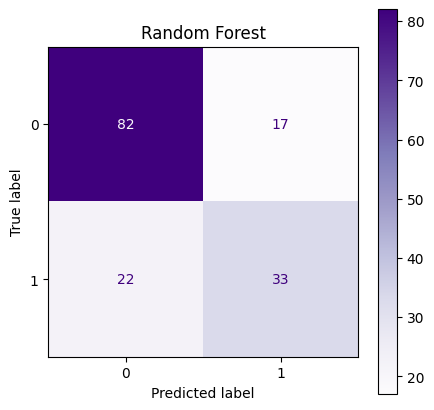

In [ ]:
param_grid_rf = {
    'n_estimators': list(range(40,150,10)),
    'max_depth': [5,6,4],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2,3,4],
    'max_leaf_nodes': [11,12,13],
    'ccp_alpha': [0.01,0.005,0.001,0.0005]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid_rf, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train, y_train)

# Best Random Forest model
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Print results
print("\nRandom Forest Results:")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Cross-Validation Accuracy: {grid_rf.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf,digits=4))

# Fix confusion matrix plotting
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Purples', ax=ax)
ax.set_title("Random Forest")
plt.show()




### Problem 3.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [ ]:
# Insert the mean CV accuracy

a3a = 0.0                              # Just to get this cell to run without errors, put your answer here                 

print(f'a3a = {a3a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

### Problem 3.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [ ]:
# Insert the test accuracy

a3b = 0.0                              # Just to get this cell to run without errors, put your answer here 

print(f'a3b = {a3b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell